In [39]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [40]:
import requests
from PIL import Image
from io import BytesIO

import copy

In [41]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

In [42]:
numb_batch = 64

#Getting Data

In [43]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


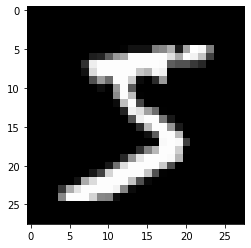

In [44]:
plt.imshow(train_data[0][0][0], cmap = "gray")

#Creating the Model

In [45]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

#Validating the Model

In [46]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

#Training Function

In [47]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

#GPU Availability

In [48]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

No Cuda Available


device(type='cpu')

#Training the Model

In [49]:
lenet = train(40, device=device)


AssertionError: Torch not compiled with CUDA enabled

#Saving the model

In [51]:
torch.save(lenet.state_dict(), "lenet.pth")

NameError: name 'lenet' is not defined

#Optional: Loading the saved model

In [52]:
lenet = create_lenet().to(device)
lenet.load_state_dict(torch.load("lenet.pth"))
lenet.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'lenet.pth'

In [53]:
#Creating the Function to test validation data

In [54]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [55]:
y_pred, y_true = predict_dl(lenet, val_dl)

AssertionError: Torch not compiled with CUDA enabled

In [56]:
#Confusion Matrix

In [57]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

NameError: name 'y_true' is not defined

In [58]:
#Define Inference function to get prediction for any given image

In [59]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

In [63]:
#Getting the image from the web

In [64]:
path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

In [65]:
#Showing the image

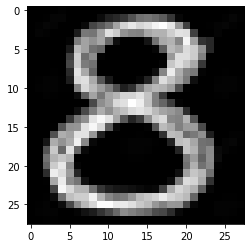

In [66]:
plt.imshow(x.squeeze(-1), cmap="gray")

In [67]:
#Predictions

In [68]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 8, Prob: 11.101661622524261 %


In [69]:
pred

array([[0.09277   , 0.09763285, 0.09156657, 0.10440112, 0.09876423,
        0.0964259 , 0.100979  , 0.09674966, 0.11101662, 0.10969406]],
      dtype=float32)